## Import package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Import

In [2]:
df_train=pd.read_csv("./original_data/mitbih_train.csv")
df_test=pd.read_csv("./original_data/mitbih_test.csv")

In [3]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [4]:
X_train_=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

## Resampling

In [5]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 20000}, random_state=13) 
over_sampler = SMOTETomek(sampling_strategy={1: 20000, 
                                        2: 20000, 
                                        3: 20000, 
                                        4: 20000},random_state=13)

pipeline = Pipeline([
    ('under', under_sampler), 
    ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_, y_train)


In [6]:
label_map = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

class_counts = y_train.value_counts().sort_index()

class_labels = [label_map[i] for i in class_counts.index]

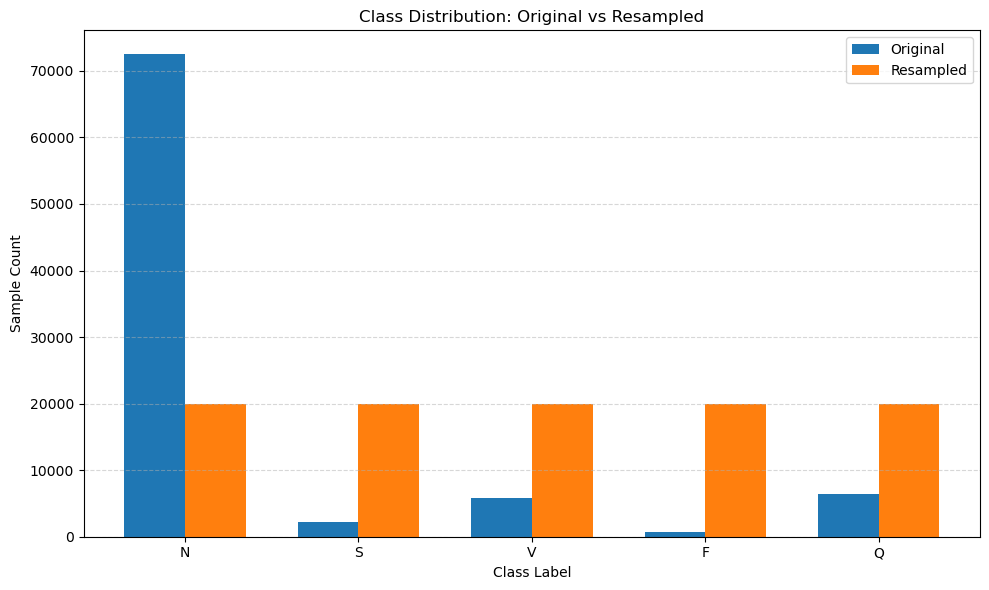

In [7]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, class_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## CNN

In [8]:
# import torch and relative functions

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [9]:
# Modify data and data loader

X_train_tensor = torch.tensor(X_resampled.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_resampled.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [10]:
#define plot structure
def plot_losses(train_losses, test_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
class ECG_CNN_1D_v1(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:

class ECG_CNN_1D_v2(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [24]:
class ECG_CNN_1D_v3(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)
        

        self.fc1 = nn.Linear(128, 64)
        self.drop_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)
        return x

In [25]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, downsample=False):
        super().__init__()
        padding = kernel_size // 2
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 64, num_blocks=2, downsample=False)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, downsample=True)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, downsample=True)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, downsample=True)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, downsample):
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, downsample=downsample))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [28]:
# parameters of model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECG_CNN_1D_v1().to(device)
num_epochs = 30
learning_rate= 1e-4
weight_decay= 5e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
test_losses = []

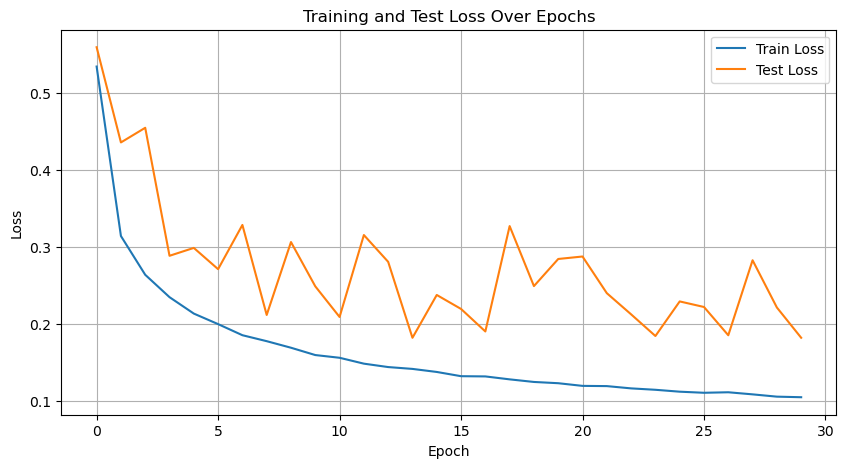

In [29]:


# from sklearn.metrics import recall_score
# def custom_weighted_recall(y_true, y_pred):
#     recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4])
#     weights = np.array([0.1, 1, 1, 1, 0.5])
#     return np.sum(recalls * weights) / np.sum(weights)

# training
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # weighted_recall = custom_weighted_recall(np.array(all_labels), np.array(all_preds))

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, "
        #   f"Weighted Recall: {weighted_recall:.4f}"
        )
    
    plot_losses(train_losses, test_losses)

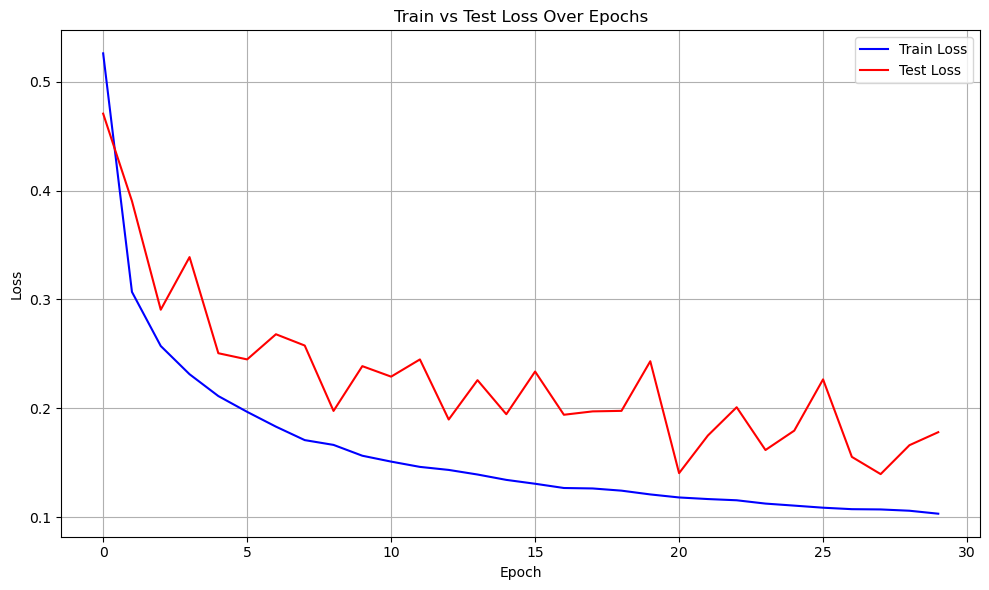

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())


print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.957     0.973     18117
           1      0.432     0.791     0.559       556
           2      0.915     0.941     0.928      1448
           3      0.556     0.883     0.683       162
           4      0.980     0.984     0.982      1608

    accuracy                          0.953     21891
   macro avg      0.775     0.911     0.825     21891
weighted avg      0.967     0.953     0.958     21891



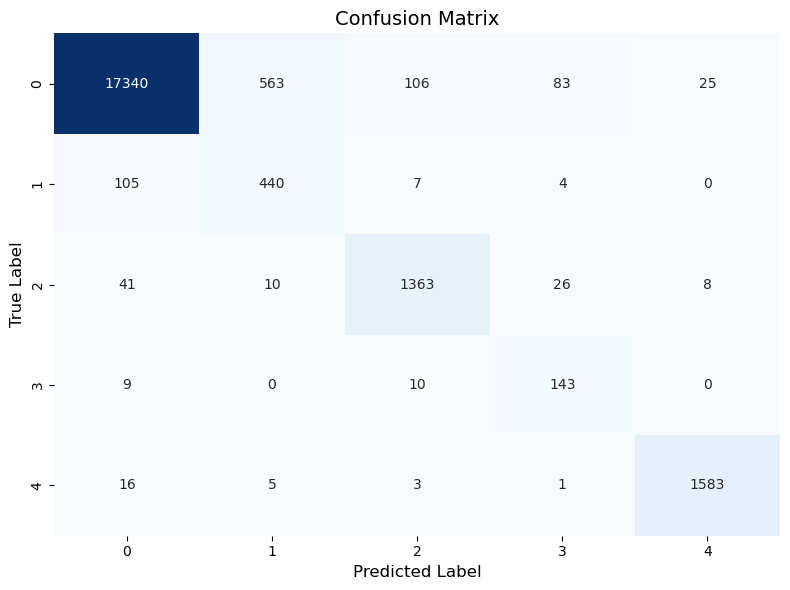

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'cnn_model.pkl')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# 自定义 weighted recall
def custom_weighted_recall(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4])
    weights = np.array([0.1, 1, 1, 1, 0.5])
    return np.sum(recalls * weights) / np.sum(weights)

# 主交叉验证函数
def run_kfold_training(model_class, X, y, k_folds=5, num_epochs=30, batch_size=64, learning_rate=1e-4, weight_decay=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    y_tensor = torch.tensor(y, dtype=torch.long)

    fold_recalls = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f'\n Fold {fold+1}/{k_folds}')

        # 划分数据
        train_dataset = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
        val_dataset = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # 模型、优化器
        model = model_class().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses = [], []

        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            train_losses.append(total_train_loss / len(train_loader))

            # 评估
            model.eval()
            total_val_loss = 0
            all_preds, all_labels = [], []

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    total_val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(batch_y.cpu().numpy())

            val_losses.append(total_val_loss / len(val_loader))
            recall = custom_weighted_recall(np.array(all_labels), np.array(all_preds))

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Weighted Recall: {recall:.4f}")

        # 当前 fold recall
        final_recall = custom_weighted_recall(np.array(all_labels), np.array(all_preds))
        fold_recalls.append(final_recall)

        # 每折绘图
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='red')
        plt.title(f'Fold {fold+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    print(f"\n 平均 Weighted Recall over {k_folds} folds: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
    return fold_recalls


 Fold 1/5
Epoch 1/100, Train Loss: 0.5860, Val Loss: 0.4055, Weighted Recall: 0.8681
Epoch 2/100, Train Loss: 0.3410, Val Loss: 0.3184, Weighted Recall: 0.8892
Epoch 3/100, Train Loss: 0.2851, Val Loss: 0.2747, Weighted Recall: 0.9110
Epoch 4/100, Train Loss: 0.2530, Val Loss: 0.2344, Weighted Recall: 0.9188
Epoch 5/100, Train Loss: 0.2303, Val Loss: 0.2146, Weighted Recall: 0.9339
Epoch 6/100, Train Loss: 0.2135, Val Loss: 0.2061, Weighted Recall: 0.9266
Epoch 7/100, Train Loss: 0.1987, Val Loss: 0.2000, Weighted Recall: 0.9245
Epoch 8/100, Train Loss: 0.1876, Val Loss: 0.1729, Weighted Recall: 0.9464
Epoch 9/100, Train Loss: 0.1790, Val Loss: 0.1822, Weighted Recall: 0.9322
Epoch 10/100, Train Loss: 0.1700, Val Loss: 0.1684, Weighted Recall: 0.9481
Epoch 11/100, Train Loss: 0.1650, Val Loss: 0.1634, Weighted Recall: 0.9433
Epoch 12/100, Train Loss: 0.1584, Val Loss: 0.1649, Weighted Recall: 0.9452
Epoch 13/100, Train Loss: 0.1529, Val Loss: 0.1566, Weighted Recall: 0.9465
Epoch 14/1

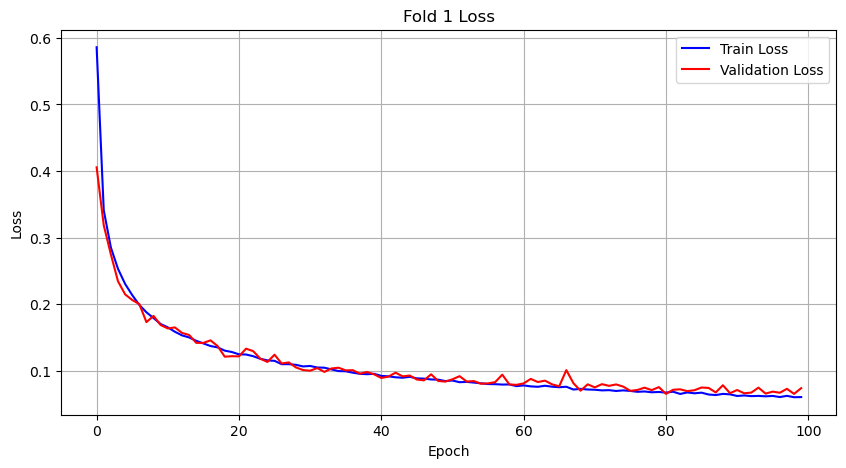


 Fold 2/5
Epoch 1/100, Train Loss: 0.5729, Val Loss: 0.3683, Weighted Recall: 0.8876
Epoch 2/100, Train Loss: 0.3249, Val Loss: 0.2958, Weighted Recall: 0.8899
Epoch 3/100, Train Loss: 0.2743, Val Loss: 0.2520, Weighted Recall: 0.9083
Epoch 4/100, Train Loss: 0.2438, Val Loss: 0.2422, Weighted Recall: 0.9089
Epoch 5/100, Train Loss: 0.2220, Val Loss: 0.2051, Weighted Recall: 0.9372
Epoch 6/100, Train Loss: 0.2052, Val Loss: 0.1979, Weighted Recall: 0.9266
Epoch 7/100, Train Loss: 0.1956, Val Loss: 0.1813, Weighted Recall: 0.9573
Epoch 8/100, Train Loss: 0.1831, Val Loss: 0.1679, Weighted Recall: 0.9548
Epoch 9/100, Train Loss: 0.1739, Val Loss: 0.1627, Weighted Recall: 0.9496
Epoch 10/100, Train Loss: 0.1642, Val Loss: 0.1591, Weighted Recall: 0.9448
Epoch 11/100, Train Loss: 0.1604, Val Loss: 0.1481, Weighted Recall: 0.9599
Epoch 12/100, Train Loss: 0.1518, Val Loss: 0.1428, Weighted Recall: 0.9578
Epoch 13/100, Train Loss: 0.1488, Val Loss: 0.1409, Weighted Recall: 0.9613
Epoch 14/1

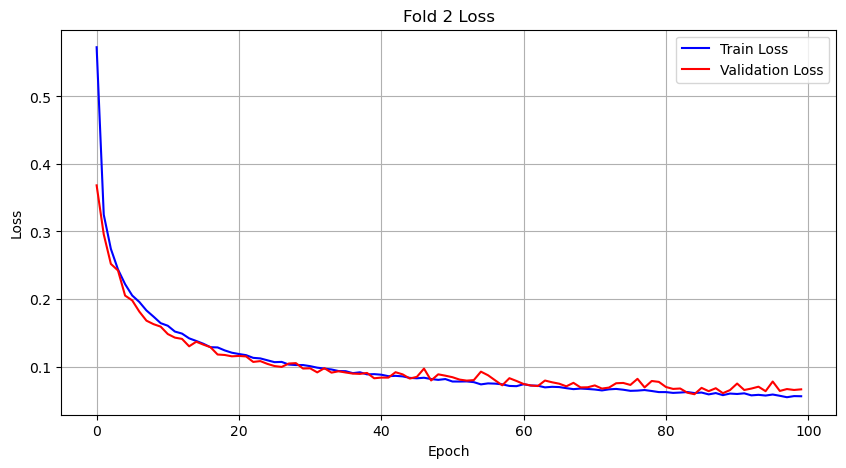


 Fold 3/5
Epoch 1/100, Train Loss: 0.5464, Val Loss: 0.3727, Weighted Recall: 0.8906
Epoch 2/100, Train Loss: 0.3178, Val Loss: 0.2913, Weighted Recall: 0.9037
Epoch 3/100, Train Loss: 0.2650, Val Loss: 0.2608, Weighted Recall: 0.9046
Epoch 4/100, Train Loss: 0.2325, Val Loss: 0.2231, Weighted Recall: 0.9308
Epoch 5/100, Train Loss: 0.2104, Val Loss: 0.2027, Weighted Recall: 0.9320
Epoch 6/100, Train Loss: 0.1972, Val Loss: 0.1912, Weighted Recall: 0.9382
Epoch 7/100, Train Loss: 0.1837, Val Loss: 0.1830, Weighted Recall: 0.9583
Epoch 8/100, Train Loss: 0.1738, Val Loss: 0.1754, Weighted Recall: 0.9397
Epoch 9/100, Train Loss: 0.1642, Val Loss: 0.1606, Weighted Recall: 0.9412
Epoch 10/100, Train Loss: 0.1570, Val Loss: 0.1531, Weighted Recall: 0.9511
Epoch 11/100, Train Loss: 0.1488, Val Loss: 0.1449, Weighted Recall: 0.9502
Epoch 12/100, Train Loss: 0.1461, Val Loss: 0.1499, Weighted Recall: 0.9426
Epoch 13/100, Train Loss: 0.1397, Val Loss: 0.1422, Weighted Recall: 0.9480
Epoch 14/1

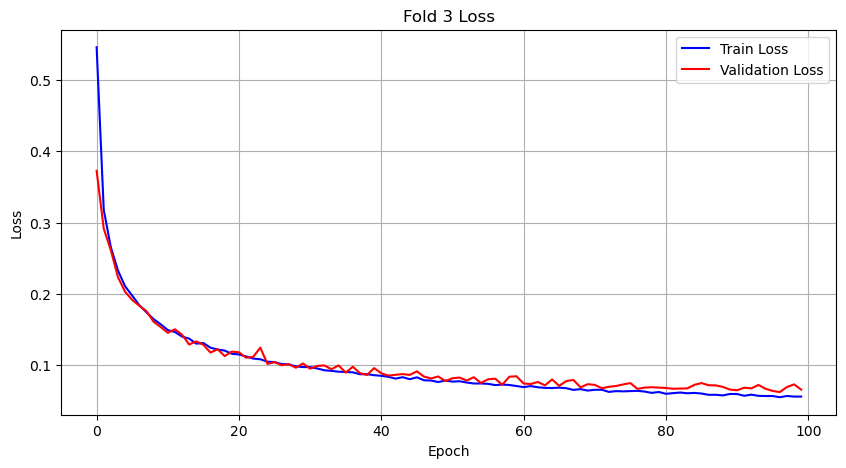


 Fold 4/5
Epoch 1/100, Train Loss: 0.5687, Val Loss: 0.3785, Weighted Recall: 0.8829
Epoch 2/100, Train Loss: 0.3280, Val Loss: 0.2935, Weighted Recall: 0.8986
Epoch 3/100, Train Loss: 0.2729, Val Loss: 0.2455, Weighted Recall: 0.9299
Epoch 4/100, Train Loss: 0.2422, Val Loss: 0.2227, Weighted Recall: 0.9313
Epoch 5/100, Train Loss: 0.2181, Val Loss: 0.2073, Weighted Recall: 0.9274
Epoch 6/100, Train Loss: 0.2043, Val Loss: 0.1948, Weighted Recall: 0.9285
Epoch 7/100, Train Loss: 0.1902, Val Loss: 0.1759, Weighted Recall: 0.9407
Epoch 8/100, Train Loss: 0.1804, Val Loss: 0.1661, Weighted Recall: 0.9525
Epoch 9/100, Train Loss: 0.1714, Val Loss: 0.1505, Weighted Recall: 0.9651
Epoch 10/100, Train Loss: 0.1649, Val Loss: 0.1525, Weighted Recall: 0.9605
Epoch 11/100, Train Loss: 0.1578, Val Loss: 0.1489, Weighted Recall: 0.9545
Epoch 12/100, Train Loss: 0.1520, Val Loss: 0.1412, Weighted Recall: 0.9630
Epoch 13/100, Train Loss: 0.1490, Val Loss: 0.1458, Weighted Recall: 0.9548
Epoch 14/1

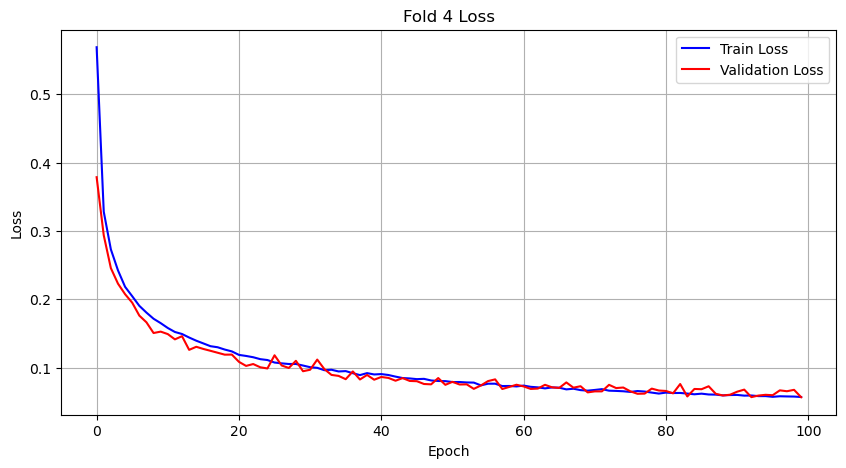


 Fold 5/5
Epoch 1/100, Train Loss: 0.5819, Val Loss: 0.3821, Weighted Recall: 0.8697
Epoch 2/100, Train Loss: 0.3242, Val Loss: 0.2947, Weighted Recall: 0.9202
Epoch 3/100, Train Loss: 0.2694, Val Loss: 0.2585, Weighted Recall: 0.9205
Epoch 4/100, Train Loss: 0.2393, Val Loss: 0.2445, Weighted Recall: 0.9253
Epoch 5/100, Train Loss: 0.2195, Val Loss: 0.2097, Weighted Recall: 0.9299
Epoch 6/100, Train Loss: 0.2033, Val Loss: 0.1972, Weighted Recall: 0.9473
Epoch 7/100, Train Loss: 0.1911, Val Loss: 0.1963, Weighted Recall: 0.9317
Epoch 8/100, Train Loss: 0.1808, Val Loss: 0.1766, Weighted Recall: 0.9468
Epoch 9/100, Train Loss: 0.1736, Val Loss: 0.1792, Weighted Recall: 0.9477
Epoch 10/100, Train Loss: 0.1634, Val Loss: 0.1655, Weighted Recall: 0.9397
Epoch 11/100, Train Loss: 0.1573, Val Loss: 0.1556, Weighted Recall: 0.9497
Epoch 12/100, Train Loss: 0.1514, Val Loss: 0.1566, Weighted Recall: 0.9475
Epoch 13/100, Train Loss: 0.1458, Val Loss: 0.1491, Weighted Recall: 0.9587
Epoch 14/1

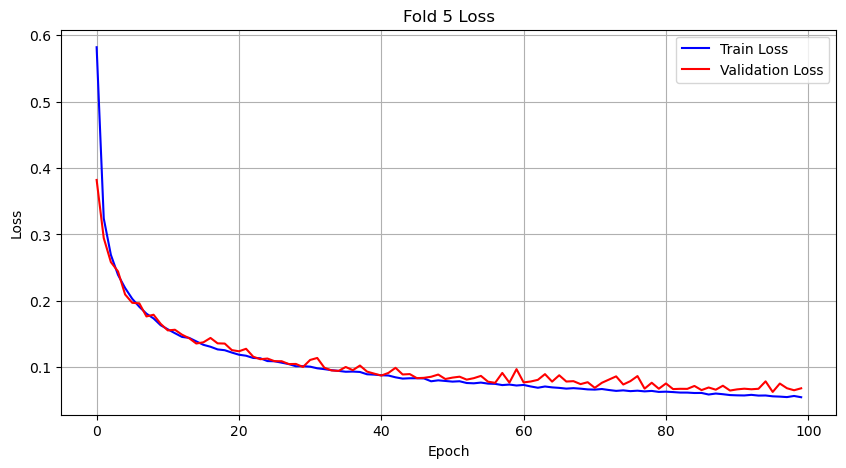


 平均 Weighted Recall over 5 folds: 0.9821 ± 0.0047


In [ ]:
recalls = run_kfold_training(ECG_CNN_1D_v1, X_resampled.values, y_resampled.values, k_folds=5, num_epochs=100)

In [ ]:
# 用整个训练数据重新训练一个模型
final_model = ECG_CNN_1D_v1().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_resampled.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_resampled.values, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

# 训练（可封装）
for epoch in range(50):  # 可调整
    final_model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 用 test 集验证
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

final_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = final_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# 评估指标
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, digits=4))
print("Custom Weighted Recall:", custom_weighted_recall(np.array(all_labels), np.array(all_preds)))

              precision    recall  f1-score   support

           0     0.9933    0.9454    0.9687     18117
           1     0.3704    0.8327    0.5127       556
           2     0.9072    0.9523    0.9292      1448
           3     0.5854    0.8889    0.7059       162
           4     0.9767    0.9913    0.9840      1608

    accuracy                         0.9459     21891
   macro avg     0.7666    0.9221    0.8201     21891
weighted avg     0.9675    0.9459    0.9537     21891

Custom Weighted Recall: 0.906709181508808


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 生成混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 可视化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()

NameError: name 'all_labels' is not defined

In [ ]:
torch.cuda.device_count()

1